## Blackjack Simulation

Simulation Setup

In [1]:
import random
import pandas as pd
import numpy as np

In [2]:
#Create objects to use for running a single game of blackjack

#Define a card's rank and suit
class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
        if rank == "Ace":
            self.value = 11
        elif rank in ["King", "Queen", "Jack"]:
            self.value = 10
        else:
            self.value = int(rank)        

    def __str__(self):
        return f"{self.rank} of {self.suit}"

#Create a randomized deck of cards
class Deck:
    ranks = ["Ace", "2", "3", "4", "5", "6", "7", "8", "9", "10", "Jack", "Queen", "King"]
    suits = ["Hearts", "Diamonds", "Clubs", "Spades"]

    def __init__(self, num_decks):
        self.cards = [Card(rank, suit) for rank in self.ranks for suit in self.suits for _ in range(num_decks)]
        random.shuffle(self.cards)

    def deal_card(self):
        return self.cards.pop()

#Object for a player's hand    
class Hand:
    def __init__(self):
        self.cards = []
        self.value = 0
        self.aces = 0

    def add_card(self, card):
        self.cards.append(card)
        self.value += card.value
        if card.rank == "Ace":
            self.aces += 1
        if self.value > 21 and self.aces: #If over 21 and player has an ace, subtract 10
            self.value -= 10
            self.aces -= 1

    def card_value(self, card):
        if card.rank in ["2", "3", "4", "5", "6", "7", "8", "9", "10"]:
            return int(card.rank)
        elif card.rank in ["Jack", "Queen", "King"]:
            return 10
        else:
            return 11

#Run one hand
class Game:
    def __init__(self, stay_value, num_decks, starting_bet):
        self.deck = Deck(num_decks)
        self.player_hand = Hand()
        self.dealer_hand = Hand()
        self.stay_value = stay_value
        self.starting_bet = starting_bet
        self.current_bet = starting_bet
        self.profit = 0
    
    def play(self):
        for i in range(2):
            self.player_hand.add_card(self.deck.deal_card())
            self.dealer_hand.add_card(self.deck.deal_card())
        if self.player_hand.value == 21: #Blackjack
            self.profit += (self.current_bet * 1.2)
            return "Player wins!"
        while True:
            if self.player_hand.value > 21: #Player bust
                self.profit -= self.current_bet
                return "Dealer wins!"
            if self.player_hand.value == 21: #Player blackjack
                break
            if self.player_hand.value >= self.stay_value: #Higher than stay value
                break
            self.player_hand.add_card(self.deck.deal_card()) #Player draw card if less than stay value
        while True:
            if self.dealer_hand.value >= 17: #Dealer higher than 17
                break
            self.dealer_hand.add_card(self.deck.deal_card()) #Dealer draw card if under 17
        if self.dealer_hand.value > 21: #Dealer bust
            self.profit += self.current_bet
            return "Player wins!"
        if self.player_hand.value > self.dealer_hand.value: #Player higher than dealer
            self.profit += self.current_bet
            return "Player wins!"
        elif self.player_hand.value == self.dealer_hand.value: #Tie
            return "Tie"
        else:
            self.profit -= self.current_bet
            return "Dealer wins!"

In [3]:
#One single simulation of x iterations

def simulate(num_hands, stay_value, num_decks, starting_bet, martingale=False):
    results = {"Stay Value": stay_value, "# of Decks": num_decks, "Wins": 0, "Losses": 0, "Ties": 0, "Largest Bet": starting_bet}
    profit = 0
    bet = starting_bet
    for i in range(num_hands):
        game = Game(stay_value, num_decks, bet)
        result = game.play()
        if result == "Player wins!":
            results["Wins"] += 1
            if martingale:
                bet = starting_bet
        elif result == "Dealer wins!":
            results["Losses"] += 1
            if martingale:
                bet *= 2
                if bet > results["Largest Bet"]:
                    results["Largest Bet"] = bet/2
            profit -= bet - bet
        else:
            results["Ties"] += 1
            if martingale:
                bet = bet
        profit += game.profit
    results["Profit"] = profit
    df = pd.DataFrame(results, index=[1])
    df[['Wins','Losses','Ties']] = (df[['Wins','Losses','Ties']] / num_hands)*100
    return df

In [4]:
#Test one basic run

#simulate -> (num_hands, stay_value, num_decks, starting_bet, martingale=False)
simulate(10000, 11, 1, 10, martingale = False)

,Stay Value,# of Decks,Wins,Losses,Ties,Largest Bet,Profit
1,11,1,39.7,54.59,5.71,10,-13934.0


Data Cleaning

In [5]:
#Function to create dataframe for all stay_values and each number of decks

def make_dataframe(num_hands, starting_bet, martingale=False):
    dfs = []
    for stay_value in range(11,21):
        for num_decks in [1,2,6]:
            df = simulate(num_hands, stay_value, num_decks, starting_bet, martingale)
            dfs.append(df)
    result = pd.concat(dfs)
    return result

In [6]:
#Had to create 2 separate dfs for martingale vs. no martingale because the code would break when trying to run it all together

#make_dataframe -> (num_hands, starting_bet, martingale=False)
#No martingale
mgale_no = make_dataframe(10000, 10, martingale=False)
mgale_no.head()

,Stay Value,# of Decks,Wins,Losses,Ties,Largest Bet,Profit
1,11,1,41.23,53.13,5.64,10,-10944.0
1,11,2,40.39,54.00,5.61,10,-12680.0
1,11,6,40.69,53.83,5.48,10,-12158.0
1,12,1,41.96,51.50,6.54,10,-8514.0
1,12,2,41.73,51.99,6.28,10,-9288.0


In [7]:
#make_dataframe -> (num_hands, starting_bet, martingale=True)

#Yes martingale
mgale_yes = make_dataframe(10000, 10, martingale=True)
mgale_yes.head()

,Stay Value,# of Decks,Wins,Losses,Ties,Largest Bet,Profit
1,11,1,40.83,53.44,5.73,327680.0,52656.0
1,11,2,40.57,53.77,5.66,40960.0,49002.0
1,11,6,39.81,54.32,5.87,655360.0,60574.0
1,12,1,41.33,52.92,5.75,20480.0,55620.0
1,12,2,42.44,51.73,5.83,20480.0,50492.0


In [8]:
#Combine the dataframes and clean up/reformat data

df_combine_num = mgale_no.merge(mgale_yes, how='inner',on=['Stay Value','# of Decks'])
df_combine = df_combine_num.rename(columns={'Wins_x':'Win%','Losses_x':'Loss%','Ties_x':'Tie%','Largest Bet_x':'Bet Amount','Profit_x':'Profit Basic',
                                        'Wins_y':'MG Win%','Losses_y':'MG Loss%','Ties_y':'MG Tie%','Largest Bet_y':'Largest MG Bet','Profit_y':'MG Profit'})
df_combine[['Win%','Loss%','Tie%','MG Win%','MG Loss%','MG Tie%']] = df_combine[['Win%','Loss%','Tie%','MG Win%','MG Loss%','MG Tie%']].round(2).apply(lambda x: x.astype(str)+'%')
df_combine[['Bet Amount','Profit Basic','Largest MG Bet','MG Profit']] = df_combine[['Bet Amount','Profit Basic','Largest MG Bet','MG Profit']].round().astype(int).apply(lambda x: "$ "+ x.astype(str))
df_combine

,Stay Value,# of Decks,Win%,Loss%,Tie%,Bet Amount,Profit Basic,MG Win%,MG Loss%,MG Tie%,Largest MG Bet,MG Profit
0,11,1,41.23%,53.13%,5.64%,$ 10,$ -10944,40.83%,53.44%,5.73%,$ 327680,$ 52656
1,11,2,40.39%,54.0%,5.61%,$ 10,$ -12680,40.57%,53.77%,5.66%,$ 40960,$ 49002
2,11,6,40.69%,53.83%,5.48%,$ 10,$ -12158,39.81%,54.32%,5.87%,$ 655360,$ 60574
3,12,1,41.96%,51.5%,6.54%,$ 10,$ -8514,41.33%,52.92%,5.75%,$ 20480,$ 55620
4,12,2,41.73%,51.99%,6.28%,$ 10,$ -9288,42.44%,51.73%,5.83%,$ 20480,$ 50492
5,12,6,41.73%,52.5%,5.77%,$ 10,$ -9826,42.37%,51.64%,5.99%,$ 655360,$ 59098
6,13,1,43.01%,50.16%,6.83%,$ 10,$ -6226,43.36%,50.53%,6.11%,$ 81920,$ 69278
7,13,2,42.47%,50.0%,7.53%,$ 10,$ -6562,41.75%,51.32%,6.93%,$ 40960,$ 50958
8,13,6,42.24%,51.08%,6.68%,$ 10,$ -7838,43.36%,49.9%,6.74%,$ 20480,$ 50266
9,14,1,43.25%,49.58%,7.17%,$ 10,$ -5374,42.82%,50.1%,7.08%,$ 20480,$ 52518


Outputs & Analysis

In [9]:
#Perform F-test to compare means of 1 vs 2 vs 6 decks
from scipy.stats import f_oneway

# Generate three sets of samples based on the number of decks
deck1=df_combine_num.iloc[::3, :][['Stay Value','# of Decks','Wins_x']] #1 deck
deck2=df_combine_num.iloc[1::3, :][['Stay Value','# of Decks','Wins_x']] #2 decks
deck6=df_combine_num.iloc[2::3, :][['Stay Value','# of Decks','Wins_x']] #3 decks

# Perform ANOVA F-test
f_stat, p_val = f_oneway(deck1['Wins_x'], deck2['Wins_x'], deck6['Wins_x'])

print("F-statistic:", f_stat)
print("p-value:", p_val)

#deck6.head()

/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


F-statistic: 0.007164102648074476
p-value: 0.9928633850299591


In [10]:
#Create charts for analyzing most optimal stay value
import matplotlib.pyplot as plt

df_stay=df_combine_num.groupby('Stay Value')[['Wins_x','Ties_x','Profit_x']].mean().reset_index()
df_stay['Win+Tie%']=df_stay['Wins_x']+df_stay['Ties_x']
df_stay.head(10)

,Stay Value,Wins_x,Ties_x,Profit_x,Win+Tie%
0,11,40.770000,5.576667,-11927.333333,46.346667
1,12,41.806667,6.196667,-9209.333333,48.003333
2,13,42.573333,7.013333,-6875.333333,49.586667
3,14,42.756667,7.403333,-6120.666667,50.160000
4,15,42.243333,8.293333,-6252.666667,50.536667
5,16,42.233333,8.970000,-5604.000000,51.203333
6,17,41.516667,9.743333,-6296.666667,51.260000
7,18,40.270000,8.333333,-10178.666667,48.603333
8,19,36.756667,7.023333,-18450.666667,43.780000
9,20,30.130000,5.223333,-33546.666667,35.353333


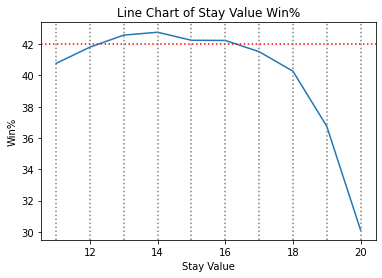

42.75666666666667


In [11]:
#Line chart for win% for each stay value
plt.plot(df_stay['Stay Value'],df_stay['Wins_x'])

# Add labels, straight lines, and title
plt.axhline(y=42, linestyle=':', color='red')
plt.axvline(x=11, linestyle=':', color='grey')
plt.axvline(x=12, linestyle=':', color='grey')
plt.axvline(x=13, linestyle=':', color='grey')
plt.axvline(x=14, linestyle=':', color='grey')
plt.axvline(x=15, linestyle=':', color='grey')
plt.axvline(x=16, linestyle=':', color='grey')
plt.axvline(x=17, linestyle=':', color='grey')
plt.axvline(x=18, linestyle=':', color='grey')
plt.axvline(x=19, linestyle=':', color='grey')
plt.axvline(x=20, linestyle=':', color='grey')

plt.xlabel('Stay Value')
plt.ylabel('Win%')
plt.title('Line Chart of Stay Value Win%')

# Display the plot
plt.show()
max1 = df_stay['Wins_x'].max()
print(max1)

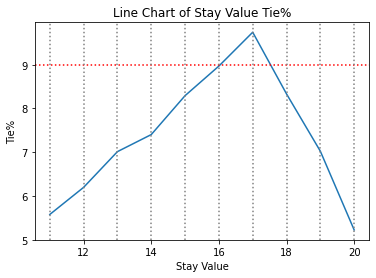

9.743333333333334


In [16]:
#Line chart for tie% for each stay value
plt.plot(df_stay['Stay Value'],df_stay['Ties_x'])

# Add labels, straight lines, and title
plt.axhline(y=9, linestyle=':', color='red')
plt.axvline(x=11, linestyle=':', color='grey')
plt.axvline(x=12, linestyle=':', color='grey')
plt.axvline(x=13, linestyle=':', color='grey')
plt.axvline(x=14, linestyle=':', color='grey')
plt.axvline(x=15, linestyle=':', color='grey')
plt.axvline(x=16, linestyle=':', color='grey')
plt.axvline(x=17, linestyle=':', color='grey')
plt.axvline(x=18, linestyle=':', color='grey')
plt.axvline(x=19, linestyle=':', color='grey')
plt.axvline(x=20, linestyle=':', color='grey')

plt.xlabel('Stay Value')
plt.ylabel('Tie%')
plt.title('Line Chart of Stay Value Tie%')

# Display the plot
plt.show()
max_tie = df_stay['Ties_x'].max()
print(max_tie)

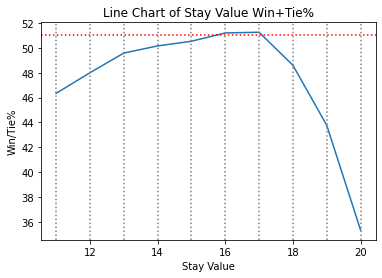

51.26


In [17]:
#Line chart for win+tie% for each stay value
plt.plot(df_stay['Stay Value'],df_stay['Win+Tie%'])

# Add labels, straight lines, and title
plt.axhline(y=51, linestyle=':', color='red')
plt.axvline(x=11, linestyle=':', color='grey')
plt.axvline(x=12, linestyle=':', color='grey')
plt.axvline(x=13, linestyle=':', color='grey')
plt.axvline(x=14, linestyle=':', color='grey')
plt.axvline(x=15, linestyle=':', color='grey')
plt.axvline(x=16, linestyle=':', color='grey')
plt.axvline(x=17, linestyle=':', color='grey')
plt.axvline(x=18, linestyle=':', color='grey')
plt.axvline(x=19, linestyle=':', color='grey')
plt.axvline(x=20, linestyle=':', color='grey')

plt.xlabel('Stay Value')
plt.ylabel('Win/Tie%')
plt.title('Line Chart of Stay Value Win+Tie%')

# Display the plot
plt.show()
max_tie = df_stay['Win+Tie%'].max()
print(max_tie)

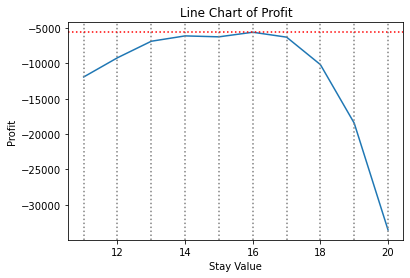

-5604.0


In [14]:
#Line chart for profit for each stay value
plt.plot(df_stay['Stay Value'],df_stay['Profit_x'])
max2 = df_stay['Profit_x'].max()

# Add labels, straight lines, and title
plt.axvline(x=11, linestyle=':', color='grey')
plt.axvline(x=12, linestyle=':', color='grey')
plt.axvline(x=13, linestyle=':', color='grey')
plt.axvline(x=14, linestyle=':', color='grey')
plt.axvline(x=15, linestyle=':', color='grey')
plt.axvline(x=16, linestyle=':', color='grey')
plt.axvline(x=17, linestyle=':', color='grey')
plt.axvline(x=18, linestyle=':', color='grey')
plt.axvline(x=19, linestyle=':', color='grey')
plt.axvline(x=20, linestyle=':', color='grey')
plt.axhline(y=max2, linestyle=':', color='red')

plt.xlabel('Stay Value')
plt.ylabel('Profit')
plt.title('Line Chart of Profit')

#Display the plot
plt.show()
print(max2)

In [15]:
#Dataframe for Martingale simulation output

pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_mg=df_combine_num.groupby('Stay Value')[['Largest Bet_y','Profit_y']].mean().reset_index()
df_mg[['Largest Bet_y','Profit_y']]=df_mg[['Largest Bet_y','Profit_y']].astype(int).apply(lambda x: "$ "+ x.astype(str))
df_mg=df_mg.rename(columns={'Largest Bet_y':'Largest Bet','Profit_y':'Profit'})
display(df_mg)

,Stay Value,Largest Bet,Profit
0,11,$ 341333,$ 54077
1,12,$ 232106,$ 55070
2,13,$ 47786,$ 56834
3,14,$ 34133,$ 51604
4,15,$ 150186,$ 56354
5,16,$ 327680,$ 49436
6,17,$ 95573,$ 56964
7,18,$ 150186,$ 49926
8,19,$ 122880,$ 72716
9,20,$ 43690666,$ 12534218
